### Dataset: Energy Efficiency with HL (heating load) as target

In [1]:
from ucimlrepo import fetch_ucirepo

energy_efficiency = fetch_ucirepo(id=242) 
  
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets

var_df = energy_efficiency.variables
col_map = dict(zip(var_df["name"], var_df["description"]))
X = X.rename(columns=col_map)
y = y.rename(columns=col_map)

y = y[["Heating Load"]]
df = X.join(y)
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


### Train test split

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,     
    random_state=42,   
    shuffle=True
)

print(f"#X_train = {len(X_train)}   #y_train = {len(y_train)}")
print(f"#X_test = {len(X_test)}     #y_test = {len(y_test)}")

#X_train = 691   #y_train = 691
#X_test = 77     #y_test = 77


### EDF normalization

In [3]:
from src.edf import edf_normalize, col_denorm

X_train_norm, X_test_norm, _ = edf_normalize(X_train, X_test)
y_train_norm, y_test_norm, edf_models = edf_normalize(y_train, y_test)

y_denorm = col_denorm("Heating Load", edf_models)

 ### Relevance

In [4]:
from src.evaluation import relevance

columns_relevance = {}
for col in X.columns:
    softplus_relevance = relevance(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="softplus"
    )
    clip_relevance = relevance(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="clip"
    )

    columns_relevance[col] = {
        "softplus": softplus_relevance,
        "clip": clip_relevance
    }

In [5]:
def report_relevance(columns_relevance, method="softplus"):
    relevance_dict = {
        col: scores[method]
        for col, scores in columns_relevance.items()
    }
    sorted_items = sorted(relevance_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Relevance Ranking (method: {method}):")
    for rank, (feature, relevance_score) in enumerate(sorted_items, start=1):
        print(f"{rank}. {feature}: {relevance_score:.4f}")

In [6]:
report_relevance(columns_relevance, method="softplus")

Feature Relevance Ranking (method: softplus):
1. Relative Compactness: 0.4496
2. Surface Area: 0.4374
3. Roof Area: 0.4049
4. Overall Height: 0.3622
5. Wall Area: 0.2668
6. Glazing Area: 0.1530
7. Glazing Area Distribution: 0.0890
8. Orientation: -0.0049


In [7]:
report_relevance(columns_relevance, method="clip")

Feature Relevance Ranking (method: clip):
1. Relative Compactness: 0.6636
2. Surface Area: 0.6438
3. Roof Area: 0.6155
4. Overall Height: 0.5769
5. Wall Area: 0.3381
6. Glazing Area: 0.1895
7. Glazing Area Distribution: 0.0933
8. Orientation: -0.0092


### Relevance (10-fold Cross Validation)

In [8]:
from src.cv import cv_relevance, print_cv_relevance, plot_cv_relevance
relevance_results = cv_relevance(X, y)

Fold 1
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluating relevance for feature: Roof Area
  Evaluating relevance for feature: Overall Height
  Evaluating relevance for feature: Orientation
  Evaluating relevance for feature: Glazing Area
  Evaluating relevance for feature: Glazing Area Distribution
Fold 2
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluating relevance for feature: Roof Area
  Evaluating relevance for feature: Overall Height
  Evaluating relevance for feature: Orientation
  Evaluating relevance for feature: Glazing Area
  Evaluating relevance for feature: Glazing Area Distribution
Fold 3
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluatin

In [9]:
print_cv_relevance(relevance_results, X.columns, method="softplus")

CV Relevance Results (method: softplus):

Feature: Relative Compactness
  per fold: [0.4  0.42 0.44 0.42 0.42 0.44 0.37 0.46 0.41 0.42]
  mean relevance : 0.4204
  std relevance  : 0.0234

Feature: Surface Area
  per fold: [0.4  0.44 0.44 0.42 0.42 0.44 0.38 0.45 0.4  0.42]
  mean relevance : 0.4219
  std relevance  : 0.0226

Feature: Wall Area
  per fold: [0.21 0.2  0.23 0.25 0.32 0.21 0.19 0.26 0.3  0.22]
  mean relevance : 0.2395
  std relevance  : 0.0417

Feature: Roof Area
  per fold: [0.39 0.38 0.41 0.38 0.44 0.37 0.35 0.42 0.39 0.39]
  mean relevance : 0.3925
  std relevance  : 0.0236

Feature: Overall Height
  per fold: [0.35 0.35 0.37 0.34 0.37 0.35 0.31 0.37 0.35 0.34]
  mean relevance : 0.3478
  std relevance  : 0.0169

Feature: Orientation
  per fold: [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.   -0.01 -0.  ]
  mean relevance : -0.0089
  std relevance  : 0.0038

Feature: Glazing Area
  per fold: [0.13 0.14 0.14 0.13 0.19 0.2  0.14 0.1  0.18 0.07]
  mean relevance : 0.142

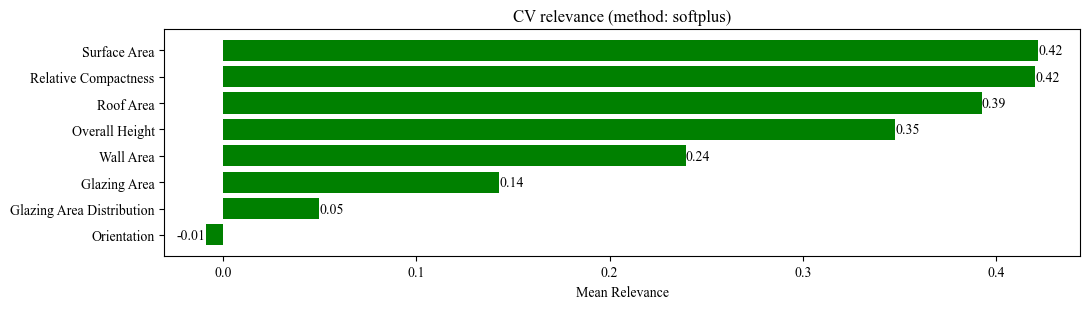

In [32]:
plot_cv_relevance(relevance_results, X.columns, method="softplus")

In [11]:
print_cv_relevance(relevance_results, X.columns, method="clip")

CV Relevance Results (method: clip):

Feature: Relative Compactness
  per fold: [0.43 0.62 0.65 0.29 0.46 0.65 0.51 0.67 0.57 0.61]
  mean relevance : 0.5453
  std relevance  : 0.1163

Feature: Surface Area
  per fold: [0.42 0.63 0.64 0.29 0.45 0.65 0.53 0.66 0.57 0.61]
  mean relevance : 0.5456
  std relevance  : 0.1181

Feature: Wall Area
  per fold: [0.09 0.18 0.23 0.02 0.27 0.23 0.21 0.38 0.41 0.29]
  mean relevance : 0.2306
  std relevance  : 0.1114

Feature: Roof Area
  per fold: [0.57 0.59 0.63 0.59 0.65 0.59 0.52 0.64 0.57 0.59]
  mean relevance : 0.5926
  std relevance  : 0.0363

Feature: Overall Height
  per fold: [0.55 0.56 0.58 0.55 0.58 0.56 0.5  0.58 0.57 0.55]
  mean relevance : 0.5573
  std relevance  : 0.0246

Feature: Orientation
  per fold: [-0.02 -0.03 -0.01 -0.02 -0.02 -0.02 -0.01 -0.01 -0.02 -0.01]
  mean relevance : -0.0169
  std relevance  : 0.0072

Feature: Glazing Area
  per fold: [0.19 0.19 0.21 0.18 0.26 0.25 0.21 0.15 0.24 0.1 ]
  mean relevance : 0.1982
  

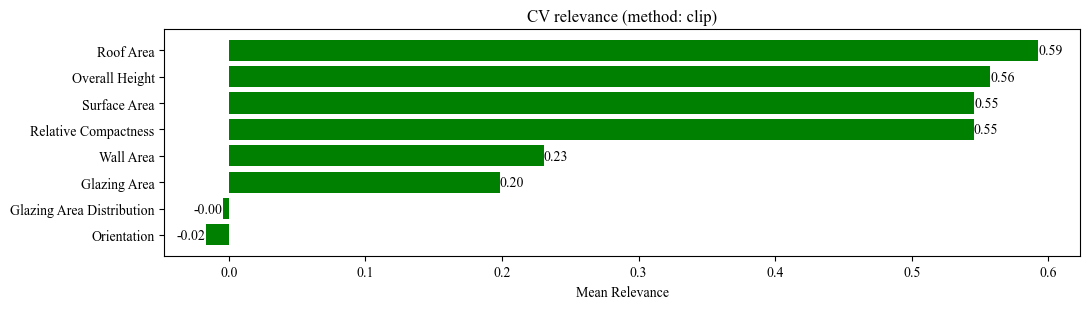

In [33]:
plot_cv_relevance(relevance_results, X.columns, method="clip")

### Novelty

In [13]:
from src.evaluation import novelty

columns_novelty = {}
for col in X.columns:
    softplus_novelty = novelty(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="softplus"
    )
    clip_novelty = novelty(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="clip"
    )

    columns_novelty[col] = {
        "softplus": softplus_novelty,
        "clip": clip_novelty
    }

In [14]:
def report_novelty(columns_novelty, method="softplus"):
    novelty_dict = {
        col: scores[method]
        for col, scores in columns_novelty.items()
    }
    sorted_items = sorted(novelty_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Novelty Ranking (method: {method}):")
    for rank, (feature, novelty_score) in enumerate(sorted_items, start=1):
        print(f"{rank}. {feature}: {novelty_score:.4f}")

In [15]:
report_novelty(columns_novelty, method="softplus")

Feature Novelty Ranking (method: softplus):
1. Glazing Area Distribution: 0.0040
2. Orientation: 0.0013
3. Overall Height: -0.0002
4. Surface Area: -0.0038
5. Relative Compactness: -0.0107
6. Glazing Area: -0.0244
7. Wall Area: -0.0371
8. Roof Area: -0.0633


In [16]:
report_novelty(columns_novelty, method="clip")

Feature Novelty Ranking (method: clip):
1. Glazing Area Distribution: 0.0062
2. Orientation: 0.0016
3. Glazing Area: 0.0000
4. Overall Height: -0.0001
5. Surface Area: -0.0047
6. Relative Compactness: -0.0127
7. Wall Area: -0.0578
8. Roof Area: -0.0827


### Novelty (10-fold Cross Validation)

In [17]:
from src.cv import cv_novelty, print_cv_novelty, plot_cv_novelty
novelty_results = cv_novelty(X, y)

Fold 1
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 2
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 3
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Eva

In [18]:
print_cv_novelty(novelty_results, X.columns, method="softplus")

CV Novelty Results (method: softplus):

Feature: Relative Compactness
  per fold: [-0.01 -0.01 -0.   -0.   -0.   -0.   -0.01 -0.   -0.   -0.  ]
  mean novelty : -0.0045
  std novelty  : 0.0021

Feature: Surface Area
  per fold: [-0. -0. -0. -0. -0. -0. -0. -0.  0. -0.]
  mean novelty : -0.0012
  std novelty  : 0.0012

Feature: Wall Area
  per fold: [-0.05 -0.02 -0.04 -0.02 -0.01 -0.04 -0.03 -0.03 -0.03 -0.05]
  mean novelty : -0.0324
  std novelty  : 0.0131

Feature: Roof Area
  per fold: [-0.06 -0.04 -0.05 -0.05 -0.03 -0.05 -0.06 -0.01 -0.03 -0.04]
  mean novelty : -0.0424
  std novelty  : 0.0136

Feature: Overall Height
  per fold: [-0.  0. -0. -0. -0.  0. -0. -0. -0. -0.]
  mean novelty : -0.0005
  std novelty  : 0.0006

Feature: Orientation
  per fold: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  mean novelty : 0.0017
  std novelty  : 0.0010

Feature: Glazing Area
  per fold: [-0.04 -0.04 -0.05 -0.03 -0.05 -0.04 -0.04 -0.02 -0.04 -0.03]
  mean novelty : -0.0390
  std novelty  : 0.0093

Featur

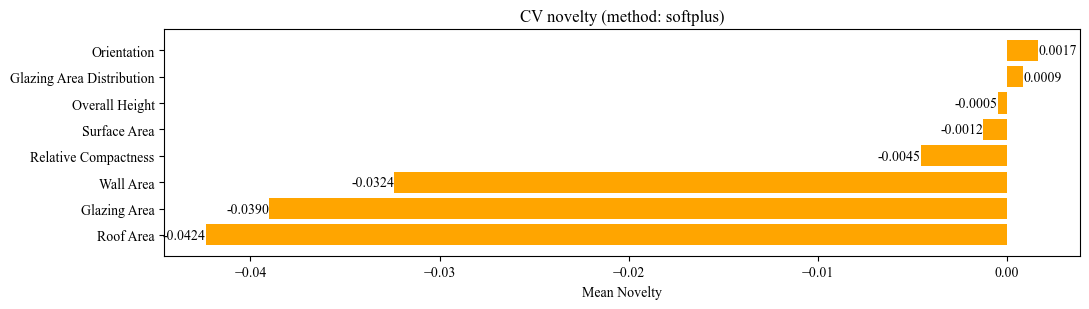

In [ ]:
plot_cv_novelty(novelty_results, X.columns, method="softplus")

In [20]:
print_cv_novelty(novelty_results, X.columns, method="clip")

CV Novelty Results (method: clip):

Feature: Relative Compactness
  per fold: [-0.01  0.   -0.01  0.   -0.01 -0.   -0.01 -0.   -0.   -0.  ]
  mean novelty : -0.0038
  std novelty  : 0.0039

Feature: Surface Area
  per fold: [-0. -0. -0. -0.  0. -0. -0. -0. -0. -0.]
  mean novelty : -0.0017
  std novelty  : 0.0014

Feature: Wall Area
  per fold: [-0.07 -0.02 -0.06 -0.01 -0.03 -0.06 -0.04 -0.04 -0.04  0.07]
  mean novelty : -0.0288
  std novelty  : 0.0386

Feature: Roof Area
  per fold: [-0.07 -0.04 -0.07 -0.04 -0.04 -0.07 -0.07 -0.02 -0.04 -0.06]
  mean novelty : -0.0523
  std novelty  : 0.0190

Feature: Overall Height
  per fold: [-0.  0. -0.  0. -0.  0. -0. -0. -0. -0.]
  mean novelty : -0.0001
  std novelty  : 0.0012

Feature: Orientation
  per fold: [0.   0.01 0.   0.01 0.   0.   0.   0.   0.   0.  ]
  mean novelty : 0.0026
  std novelty  : 0.0022

Feature: Glazing Area
  per fold: [-0.01 -0.01 -0.03 -0.01 -0.03 -0.03 -0.03  0.01 -0.01 -0.01]
  mean novelty : -0.0148
  std novelty  

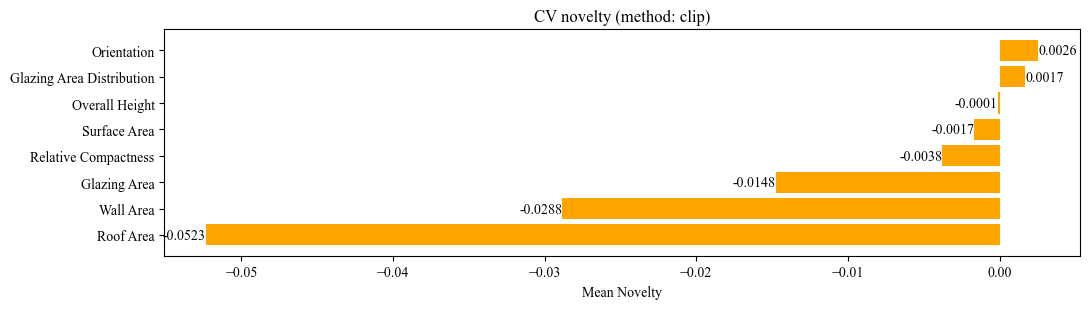

In [30]:
plot_cv_novelty(novelty_results, X.columns, method="clip")